# 대회 전략 구현하기

### ✨실습 개요<br>

1) 실습 목적 <br>
  이번 실습에서는 대회에서 사용되는 전략들을 구현해봅니다. <br>
  자연어 데이터를 증강하는 3가지 방법과, 후처리 기법인 앙상블 그리고 모델을 MLM으로 추가학습하는 코드를 구현합니다.   <br>


 2) 수강 목표
  - 자연어 데이터를 증강할 수 있다.
  - 학습 시 k-fold로 데이터를 나눌 수 있다.
  - Ensemble을 통해서 점수를 올려볼 수 있다.
  - MLM Task를 구현하고 DAPT & TAPT를 실행할 수 있다.

#### 실습 목차
1. 데이터 증강기법 살펴보기
    * 1-1. EDA 사용해보기
    * 1-2. AEDA 사용해보기
    * 1-3. Back Translation(feat. Google Translate)
2. K-fold & Ensemble
  * 2-1. K-fold 로 데이터 나누기
  * 2-2. Ensemble로 성능 올리기
3. DAPT & TAPT 구현하기
  * 3-1. 학습에 쓰일 데이터셋 준비하기
  * 3-2. 데이터셋 구성 및 마스킹하기
  * 3-3. MLM 학습하기
  


### ⚙️ 데이터 및 환경설정

- 실습에 필요한 라이브러리들을 설치합니다.
- 2-3 실습에서 사용했던 "낚시성 뉴스데이터"와 DAPT에 사용될 뉴스 더미 데이터를 불러옵니다.


1. 필요한 라이브러리 설치

In [ ]:
!pip install koeda
!pip install transformers[torch]
!pip install transformers
!pip install datasets
!pip install googletrans==4.0.0-rc1
!pip install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.4/566.4 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 35.2 MB/s eta 0:00:00
  Attempting uninstall: tweepy
    Found existing installation: tweepy 4.13.0
    Uninstalling tweepy-4.13.0:
      Successfully uninstalled tweepy-4.13.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

2. 낚시성 뉴스데이터 불러오기
> -  크기 : 18.8k rows
> - [데이터셋 링크](https://drive.google.com/drive/folders/1r7Cn1Di9s-QlPTmieCunTP_CQjKXcnxE?usp=sharing)

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1gucFY-P9a1TzdV8Xb-OwVD4TpPy4iyJX' -O train.csv
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1J05RaqfknDzTObofL7OyiSmT0B8rX0gZ' -O test.csv

--2023-10-13 01:27:44--  https://docs.google.com/uc?export=download&id=1gucFY-P9a1TzdV8Xb-OwVD4TpPy4iyJX
Resolving docs.google.com (docs.google.com)... 142.250.101.113, 142.250.101.138, 142.250.101.100, ...
Connecting to docs.google.com (docs.google.com)|142.250.101.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-1k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/b6kj9o43gr90chm2tldmlpehv25hc8jv/1697160450000/14945813140564711222/*/1gucFY-P9a1TzdV8Xb-OwVD4TpPy4iyJX?e=download&uuid=2a988fad-2931-4db2-b6cd-d9c148e99048 [following]
--2023-10-13 01:27:47--  https://doc-0g-1k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/b6kj9o43gr90chm2tldmlpehv25hc8jv/1697160450000/14945813140564711222/*/1gucFY-P9a1TzdV8Xb-OwVD4TpPy4iyJX?e=download&uuid=2a988fad-2931-4db2-b6cd-d9c148e99048
Resolving doc-0g-1k-docs.googleusercontent.com (doc-0g-1k-docs.googleusercontent.com)... 142.251.2.132, 2607:f8

In [ ]:
import pandas as pd

train_df = pd.read_csv("train.csv",index_col=0)
test_df = pd.read_csv("test.csv",index_col=0)

train_df.head(3)

,newsCategory,newsSubcategory,newsTitle,newsContent,label
12529,경제,금융/증권,김종민 대전산단협회장 “산단 발전과 인식변화 위해 노력”,“대전산업단지 발전과 인식 변화를 위해 최선의 노력을 다하겠다.” 제14대 대전산업...,1
4815,경제,유통,"힐튼 가든 인, 내달 1일 루프톱 야외 수영장 개장","힐튼 가든 인 서울 강남은 다음달 1일부터 루프톱 야외 수영장을 오픈, 온수풀을 가...",0
11556,경제,유통/쇼핑,이마트에서 겨울패션 충전,이마트가 지속되는 한파에 끝이 보이지 않는 겨울을 이기기 위한 비법으로 겨울 패션 ...,1


In [ ]:
test_df.head(3)

,newsCategory,newsSubcategory,newsTitle,newsContent,label
21851,경제,산업,"본그룹 \""일상 속 걷기로 비대면 기부 캠페인 참여해요\""",국내 대표 한식 프랜차이즈 기업 본아이에프가 속한 '본그룹'이 오늘부터 내달 16일...,1
1409,경제,경제일반,"\""그림 완성하고 미니 콘서트도\"" 아이파크몰, 체험형 콘텐츠 강화",HDC아이파크몰은 고객이 직접 참여하고 경험할 수 있는 체험형 콘텐츠를 통해 오프라...,0
15087,경제,건설/부동산,"LH 미분양아파트 소진 '진땀', 공급실적 올리기위해 알선수수료까지 지원키로",연말을 앞두고 한국토지주택공사(LH) 대전충남지역본부가 아파트 공급실적을 끌어올리기...,1


3. 뉴스 더미 데이터 불러오기
> -  크기 : 2.43M rows
> - [데이터셋 링크](https://huggingface.co/datasets/krenerd/korean-newstext-dump)

In [ ]:
from datasets import load_dataset

news_dump = load_dataset("krenerd/korean-newstext-dump",split='train')

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [ ]:
news_dump["text"][:4]

['제목: 민주당 새 당대표에 86맏형 송영길…최고위원은 ‘친문’ 강화',
 '내용: 2022년 대통령 선거를 진두지휘할 여당의 신임 당대표에 5선 송영길 의원이 당선됐다. 함께 치러진 최고위원 선거에서는 김용민 강병원 백혜련 김영배 전혜숙 의원이 당원들의 선택을 받았다. 더불어민주당 당원들은 당대표 선거에서는 ‘쇄신’을 강조한 송 의원에게, 최고위원 선거에서는 문재인정부의 성공적인 마무리를 위한 ‘친문(친문재인) 지도부’ 구성에 힘을 실어준 것으로 평가된다. ',
 ' ',
 '2일 서울 여의도 당사에서 열린 민주당 임시 전국대의원회의에서 송 신임 대표는 총득표율 35.60%로 홍영표 의원을 불과 0.59%포인트 차로 누르고 당권을 손에 쥐었다. 2위 홍 의원은 권리당원 투표에서 송 의원을 앞섰지만, 반영율이 더 큰 대의원 투표에서 밀렸다. ']

### 1️⃣ 데이터 증강기법 살펴보기

> KoEDA
- `영어용으로 구현된 Easy data augmentation 과 An Easier Data Augmentation 프로젝트를 한글용으로 재구성한 프로젝트입니다.`

#### 1-1. EDA 사용해보기
🎯 EasyDataAugmentation 파라미터
 - `p = (alpha_sr,alpha_ri,alpha_rs,prob_rd)` 은 <br> SR, RI , RS , RD 에 대한 각각의 변환을 어느정도 비율로 할 것인지 결정
 > - Synonym Replacement __(SR)__ : 유의어 교체
 > - Random Insertion __(RI)__ : 임의 단어 삽입
 > - Random Swap __(RS)__ : 두 단어 위치 변경
 > - Random Deletion __(RD)__ : 임의 단어 삭제
 - morpheme_analyzer 는 사용될 형태소 분석기를 지정하는 파라미터로, <br> ["Okt", "Kkma", "Komoran", "Mecab", "Hannanum"] 중 하나를 선택할 수 있다.  <br>__(단, 일부는 설치 필요하며, 각각 형태소를 나누는 기준이 다르다. )__

In [ ]:
# 예시 데이터 고정
ex_data = news_dump[1]['text']
ex_data

'내용: 2022년 대통령 선거를 진두지휘할 여당의 신임 당대표에 5선 송영길 의원이 당선됐다. 함께 치러진 최고위원 선거에서는 김용민 강병원 백혜련 김영배 전혜숙 의원이 당원들의 선택을 받았다. 더불어민주당 당원들은 당대표 선거에서는 ‘쇄신’을 강조한 송 의원에게, 최고위원 선거에서는 문재인정부의 성공적인 마무리를 위한 ‘친문(친문재인) 지도부’ 구성에 힘을 실어준 것으로 평가된다. '

In [ ]:
from koeda import EasyDataAugmentation

def augment_text_data_with_EDA(text,repetition):
    """입력된 문장에 대해서 EDA를 통해 데이터 증강"""
    eda = EasyDataAugmentation(
        morpheme_analyzer="Okt"
        )

    result = eda(text,p=(0.5, 0.5, 0.5, 0.5), repetition=repetition)

    # 증강 결과 출력
    print("원문: " , text)
    print("--"*100)
    for i in range(repetition):
        print(f"증강문{i+1}: ", result[i])
    # return result

In [ ]:
augment_text_data_with_EDA(ex_data,3)

원문:  내용: 2022년 대통령 선거를 진두지휘할 여당의 신임 당대표에 5선 송영길 의원이 당선됐다. 함께 치러진 최고위원 선거에서는 김용민 강병원 백혜련 김영배 전혜숙 의원이 당원들의 선택을 받았다. 더불어민주당 당원들은 당대표 선거에서는 ‘쇄신’을 강조한 송 의원에게, 최고위원 선거에서는 문재인정부의 성공적인 마무리를 위한 ‘친문(친문재인) 지도부’ 구성에 힘을 실어준 것으로 평가된다. 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
증강문1:  애인 내용 닥터 : 2022년 대통령 선거를 친분 보선 들판 진두지휘할 여당 백금 의 보선 신임 보선 친분 당대표에 보선 5선 송영길 의원 진료소 이 당선됐다. 함께 치러진 최고위원 선거에서는 백금 김용민 남자 지식 보선 강병원 백혜련 김영배 막판 전혜숙 지혜 의원이 당원들의 끝 선택을 받았다 대의원 . 더불어민주당 취지 당원들은 당대표 선거 중편 에서는 ‘쇄신’을 강조한 수일 보선 제한 신용 평원 말미 구 땅 마지막 송 의원에게, 고르 최고위원 순이익 선거에서는 피리 문재인정부의 성공적인 보선 마무리 법 를 위한 진료소 ‘친문( 영역 칼륨 친 성사 문재인 이빨 ) 지 선별 도부’ 백금 구성에 힘을 실어 하 진료소 준 유연 것으로 평가 덕성 된다.
증강문2:  내용: 2022년 대통령 선거를 진두 재평가 지휘할 의사 대성공 개혁 여당의 신임 성사 당대표에 5선 송영길 의원이 사 역설 역설 배경 당선됐다. 식 함께 치러진 최고위원 선거에서는 김용민 친교 강 예지 병원 백혜련 김영배 전혜숙 의원이 반연 당원들의 선택을 받았다. 더불어 친교 민주당 소장 재평가 당원 최종 계열 들은 의사 당대표 닥터 선거 사내 

#### 1-2. AEDA 사용해보기
🎯 AnEasierDataAugmentation 파라미터
 - `p = punc_ratio` 는 punctuations 로의 변환을 어느정도 비율로 할 것인지 결정
 - punctuations 는 ['.', ',', '!', '?', ';', ':'] 로 입력
 - morpheme_analyzer 는 사용될 형태소분석기를 지정하는 파라미터로, <br> ["Okt", "Kkma", "Komoran", "Mecab", "Hannanum"] 중 하나를 선택할 수 있다.  <br>__(단, 일부는 설치 필요하며, 각각 형태소를 나누는 기준이 다르다. )__

In [ ]:
from koeda import AEasierDataAugmentation
def augment_text_data_with_AEDA(text, repetition):
    """입력된 문장에 대해서 AEDA를 통해 데이터 증강"""
    aeda = AEasierDataAugmentation(
        morpheme_analyzer="Okt", punctuations=[".", ",", "!", "?", ";", ":"]
    )

    result = aeda(text, p=0.3, repetition=repetition)

    # 증강 결과 출력
    print("원문: " , text)
    print("--"*100)
    for i in range(repetition):
        print(f"증강문{i+1}: ", result[i])
    # return result

In [ ]:
augment_text_data_with_AEDA(ex_data,2)

원문:  내용: 2022년 대통령 선거를 진두지휘할 여당의 신임 당대표에 5선 송영길 의원이 당선됐다. 함께 치러진 최고위원 선거에서는 김용민 강병원 백혜련 김영배 전혜숙 의원이 당원들의 선택을 받았다. 더불어민주당 당원들은 당대표 선거에서는 ‘쇄신’을 강조한 송 의원에게, 최고위원 선거에서는 문재인정부의 성공적인 마무리를 위한 ‘친문(친문재인) 지도부’ 구성에 힘을 실어준 것으로 평가된다. 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
증강문1:  내용: 2022년 대통령 , 선거를 진두 ; 지휘할 여당의 신임 당대표에 5 : 선 ? 송영길 의원 . 이 당선 ? 됐다. 함께 치러진 최고위원 선거에서는 김용민 강병원 백혜련 김영배 : 전혜숙 의원이 당원들의 선택을 , 받았다. 더불어민주당 ! 당원들은 당대표 선거에서는 ‘ ; 쇄신’을 강조한 송 의원에게, : 최고위원 선거에서는 : 문재인정부의 ? 성공적인 마무리 ! 를 위한 ! ‘친문(친문재인) 지도부’ 구성에 힘을 실어 ; 준 것으로 ! 평가된다 ; .
증강문2:  : 내용: 2022년 대통령 선거를 진두지 ? 휘할 , 여당 ! 의 신임 당대표에 5선 송영길 의원이 당선됐다. 함께 치러진 최고위원 선거에서는 김용민 강병원 백혜련 김영배 전혜숙 ! 의원이 , 당원들 ; 의 선택을 받았다. ! 더불어민주당 당원들 ? 은 당대표 선거에서는 ‘쇄신’ . 을 강조한 송 의원에게, 최고위원 선거 . 에서는 문재인정부의 성공적인 ! 마무리 , 를 위한 ‘친문(친문재인) 지도부’ 구성에 ! 힘을 , 실어준 것으로 평가된다.


#### 1-3. BackTranslation (feat. Google Translate)

> 한국어 > 영어 > 한국어로 Back Translation 하기

In [ ]:
from googletrans import Translator


def augment_text_data_with_BT(text,repetition):
    """입력된 문장에 대해서 BT를 통해 데이터 증강"""
    # Translator 객체 생성
    translator = Translator()
    result = []

    # 번역 실행 (한국어 > 영어 > 한국어)
    for i in range(repetition):
        translated = translator.translate(text, src='ko', dest='en')
        re_translated = translator.translate(translated.text, src='en', dest='ko')
        result.append(re_translated.text)

    # 번역 결과 출력
    print("원문: " , text)
    print("--"*100)
    for i in range(repetition):
        print(f"증강문{i+1}: ", result[i])
    # return result

In [ ]:
augment_text_data_with_BT(ex_data,1)

원문:  내용: 2022년 대통령 선거를 진두지휘할 여당의 신임 당대표에 5선 송영길 의원이 당선됐다. 함께 치러진 최고위원 선거에서는 김용민 강병원 백혜련 김영배 전혜숙 의원이 당원들의 선택을 받았다. 더불어민주당 당원들은 당대표 선거에서는 ‘쇄신’을 강조한 송 의원에게, 최고위원 선거에서는 문재인정부의 성공적인 마무리를 위한 ‘친문(친문재인) 지도부’ 구성에 힘을 실어준 것으로 평가된다. 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
증강문1:  내용 : Song Young -Gil은 2022 년에 대통령 선거를 이끌고 여당의 새로운 당 회장에게 선출되었습니다.또한, 민주당 회원들은 당사자 선거 선거에서 Moon Jae -in 행정부의 성공적인 마무리를위한“우정”지도부의 형성을 강조한 것으로 간주된다.


>❗ 만약 Kakao brain의 pororo를 사용하고자 하신다면, <br> 로컬환경에 "torch == 1.6.0"을 설치하신 후 pororo 설치후 사용 가능

### 2️⃣ K-fold & Ensemble

> 예시용 데이터 준비
- test : 100개

In [ ]:
ex_test = test_df[:100]

In [ ]:
ex_test

,newsCategory,newsSubcategory,newsTitle,newsContent,label
21851,경제,산업,"본그룹 \""일상 속 걷기로 비대면 기부 캠페인 참여해요\""",국내 대표 한식 프랜차이즈 기업 본아이에프가 속한 '본그룹'이 오늘부터 내달 16일...,1
1409,경제,경제일반,"\""그림 완성하고 미니 콘서트도\"" 아이파크몰, 체험형 콘텐츠 강화",HDC아이파크몰은 고객이 직접 참여하고 경험할 수 있는 체험형 콘텐츠를 통해 오프라...,0
15087,경제,건설/부동산,"LH 미분양아파트 소진 '진땀', 공급실적 올리기위해 알선수수료까지 지원키로",연말을 앞두고 한국토지주택공사(LH) 대전충남지역본부가 아파트 공급실적을 끌어올리기...,1
8527,경제,정책,"신한銀, 비대면 '땡겨요 사업자 대출' 출시…최대 1000만원 가능",신한은행은 시중은행 최초로 땡겨요 입점 개인사업자를 위한 신용대출 상품인 '땡겨요 ...,0
9157,경제,정책,"[신년사]김현수 농식품부 장관 \""농업, 데이터 기반 첨단산업 변모\""",김현수 농림축산식품부 장관은 농업을 데이터 기반의 첨단산업으로 변모시키고 젊은 인재...,0
...,...,...,...,...,...
7291,경제,유통,"김정문알로에, 알랩 1포당 10억마리 유산균 장건강·면역력 ‘쑥쑥’",김정문알로에는 지난해 9월 유산균 제품 브랜드 ‘알랩’을 선보인 데 이어 ‘알랩 포...,0
8202,경제,유통,"글래드 호텔×산수음료, 친환경 유니폼 제작","글래드 호텔은 산수음료와 협업해 서울 지역 글래드 호텔(글래드 여의도, 글래드 마포...",0
22191,경제,산업,'나홀로집에' 크리스마스 혼밥이 대세...이브는 함께,"크리스마스가 하루 앞으로 다가온 24일 이브, 크리스마스 당일 혼밥 메뉴 주문이 크...",1
6007,경제,유통,"아시아나항공, 16년 연속 서비스품질 부문 '5성' 항공사 선정",아시아나항공은 영국 스카이트랙스(Skytrax)로부터 16년 연속 '서비스품질 5성...,0


####2-1.K-fold로 데이터셋 나누기

-  길이가 100인 임의 데이터셋을 k=5 fold로 나누기

In [ ]:
from sklearn.model_selection import KFold
import numpy as np

# 예시 데이터 생성
# 예를 들어, 1부터 100까지의 정수로 구성된 배열을 사용하겠습니다.
data = np.arange(1, 101)
print(f" --- 전체 데이터: {data} --- ")
print(f" --- 전체 데이터 길이 : {len(data)} --- ")

# KFold 객체 생성
# n_splits 파라미터에 원하는 fold 수를 지정합니다. 예를 들어, 5개의 fold를 생성하려면 n_splits=5로 설정합니다.
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold에 대해 학습 및 검증 데이터 인덱스 추출
for idx, (train_index, test_index) in enumerate(kf.split(data)):
    print(" ")
    print(f" ------------------------- {idx}번째 fold 입니다. ------------------------- ")
    print(f" 학습 인덱스 : {train_index} ", end='\n')
    print(f" ---------- 학습 인덱스 길이 : {len(train_index)} ----------", end='\n')
    print(" ")
    print(f" 검증 인덱스 : {test_index} ", end='\n')
    print(f" ---------- 검증 인덱스 길이 : {len(test_index)} ----------", end='\n')
    print(" ")

    train_data, test_data = data[train_index], data[test_index]
    print("학습 데이터:", train_data, "검증 데이터:", test_data, end='\n')


 --- 전체 데이터: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100] --- 
 --- 전체 데이터 길이 : 100 --- 
 
 ------------------------- 0번째 fold 입니다. ------------------------- 
 학습 인덱스 : [ 1  2  3  5  6  7  8  9 11 13 14 15 16 17 19 20 21 23 24 25 26 27 28 29
 32 34 35 36 37 38 40 41 42 43 46 47 48 49 50 51 52 54 55 56 57 58 59 60
 61 62 63 64 65 66 67 68 69 71 72 74 75 78 79 81 82 84 85 86 87 88 89 91
 92 93 94 95 96 97 98 99] 
 ---------- 학습 인덱스 길이 : 80 ----------
 
 검증 인덱스 : [ 0  4 10 12 18 22 30 31 33 39 44 45 53 70 73 76 77 80 83 90] 
 ---------- 검증 인덱스 길이 : 20 ----------
 
학습 데이터: [  2   3   4   6   7   8   9  10  12  14  15  16  17  18  20  

####2-2. Ensemble(hard voting) 통해서 성능 높여보기

- 사전학습된(pretrained) 토크나이저/모델 5가지 불러오기

In [ ]:
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
import numpy as np

model_name1 = "klue/bert-base"
model_name2 = "klue/roberta-large"
model_name3 = "monologg/koelectra-base-bias"
model_name4 = "Sunmin-dev/ko-finance_news_classifier"
model_name5 = "koliskos/fine_tuned_fake_news_classifier"


# 토크나이저 불러오기
tokenizer1 = AutoTokenizer.from_pretrained(model_name1)
tokenizer2 = AutoTokenizer.from_pretrained(model_name2)
tokenizer3 = AutoTokenizer.from_pretrained(model_name3)
tokenizer4 = AutoTokenizer.from_pretrained(model_name4)
tokenizer5 = AutoTokenizer.from_pretrained(model_name5)

# 모델 불러오기
model1 = AutoModelForSequenceClassification.from_pretrained(model_name1)
model2 = AutoModelForSequenceClassification.from_pretrained(model_name2)
model3 = AutoModelForSequenceClassification.from_pretrained(model_name3)
model4 = AutoModelForSequenceClassification.from_pretrained(model_name4)
model5 = AutoModelForSequenceClassification.from_pretrained(model_name5)

#config 확인하기
model1_config = AutoConfig.from_pretrained(model_name1)
model1_config.num_labels = 2

model2_config = AutoConfig.from_pretrained(model_name2)
model2_config.num_labels = 2

model3_config = AutoConfig.from_pretrained(model_name3)
model3_config.num_labels = 2

model4_config = AutoConfig.from_pretrained(model_name4)
model4_config.num_labels = 2

model5_config = AutoConfig.from_pretrained(model_name5)
model5_config.num_labels = 2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


- 추론에 필요한 데이터셋 클래스/토크나이징하는 함수

In [ ]:
import torch

class news_dataset(torch.utils.data.Dataset):
    """dataframe을 torch dataset class로 변환"""
    def __init__(self, news_dataset, labels):
        self.dataset = news_dataset
        self.labels = labels

    def __getitem__(self,idx):
        item = {
            key: val[idx].clone().detach() for key, val in self.dataset.items()
        }
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

def construct_tokenized_dataset(dataset,tokenizer, max_length):
    """[뉴스제목 + [SEP] + 뉴스본문]형태로 토크나이징"""
    concat_entity = []
    for title, body in zip(dataset["newsTitle"],dataset["newsContent"]):
        total = str(title) + "[SEP]" + str(body)
        concat_entity.append(total)

    tokenized_senetences = tokenizer(
        concat_entity,
        return_tensors = "pt",
        padding = True,
        truncation = True,
        max_length = max_length,
        add_special_tokens = True,
        return_token_type_ids=False, # BERT 이후 모델(RoBERTa 등) 학습할때 On
    )
    return tokenized_senetences

In [ ]:
def prepare_test_dataset(tokenizer,max_len):
    """평가(test)를 위한 데이터셋을 준비"""
    # load_data
    test_dataset = ex_test

    # split label
    test_label = test_dataset['label'].values

    # tokenizing dataset
    tokenized_test = construct_tokenized_dataset(test_dataset, tokenizer, max_len)
    print("--- tokenizing Done ---")

    # make dataset for pytorch.
    news_test_dataset = news_dataset(tokenized_test, test_label)
    print("--- dataset class Done ---")

    return news_test_dataset , test_dataset

- 추론 & 평가 진행하고 결과 파일 저장하는 함수

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from tqdm import tqdm
import os

def inference(model, tokenized_sent, device):
    """학습된(trained) 모델을 통해 결과를 추론하는 function"""
    dataloader = DataLoader(tokenized_sent, batch_size=16, shuffle=False)
    model.eval()
    output_pred = []
    for i, data in enumerate(tqdm(dataloader)):
        with torch.no_grad():
            outputs = model(
                input_ids=data["input_ids"].to(device),
                attention_mask=data["attention_mask"].to(device),
            )
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        result = np.argmax(logits, axis=-1)

        output_pred.append(result)
    return (np.concatenate(output_pred).tolist(),)

def infer_and_eval(tokenizer, model,model_name):
    """학습된 모델로 추론(infer)한 후에 예측한 결과(pred)를 평가(eval)"""
    # fix a seed
    pl.seed_everything(seed=42, workers=False)

    # set device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # set data
    news_test_dataset, test_dataset = prepare_test_dataset(tokenizer,256)

    # predict answer
    pred_answer = inference(model, news_test_dataset, device)  # model에서 class 추론
    print("--- Prediction done ---")

    # evaluate between label and prediction
    labels = test_dataset['label'].values
    pred = pred_answer[0]

    acc = accuracy_score(labels, pred)
    f1 = f1_score(labels, pred, average='macro')
    print(f" ----- accuracy:{acc * 100:.1f}% -----")
    print(f"----- f1_score(macro): {f1 * 100:.1f}% ------")

    # make csv file with predicted answer
    output = pd.DataFrame(
        {
            "title": test_dataset["newsTitle"],
            "cleanBody": test_dataset["newsContent"],
            "clickbaitClass": pred,
        }
    )

    # 최종적으로 완성된 예측한 라벨 csv 파일 형태로 저장.
    result_path = "./prediction/"
    if not os.path.exists(result_path):
        os.makedirs(result_path)
    output.to_csv(
        os.path.join(result_path,f"{model_name}.csv"), index=False
    )
    print("--- Save result ---")
    # return output

- 5가지 모델에 대해서 추론 및 평가 진행

In [ ]:
import datetime

record_time = datetime.datetime.now().strftime("%m_%d_%H_%M")

infer_and_eval(tokenizer1,model1,f"klue_bert_{record_time}")
infer_and_eval(tokenizer2,model2,f"klue_roberta_{record_time}")
infer_and_eval(tokenizer3,model3,f"koelectra_{record_time}")
infer_and_eval(tokenizer4,model4,f"kofinance_cls_{record_time}")
infer_and_eval(tokenizer5,model5,f"fakenews_cls_{record_time}")

INFO:lightning_fabric.utilities.seed:Seed set to 42


--- tokenizing Done ---
--- dataset class Done ---


100%|██████████| 7/7 [00:02<00:00,  3.37it/s]
INFO:lightning_fabric.utilities.seed:Seed set to 42


--- Prediction done ---
 ----- accuracy:61.0% -----
----- f1_score(macro): 42.2% ------
--- Save result ---
--- tokenizing Done ---
--- dataset class Done ---


100%|██████████| 7/7 [00:04<00:00,  1.68it/s]
INFO:lightning_fabric.utilities.seed:Seed set to 42


--- Prediction done ---
 ----- accuracy:38.0% -----
----- f1_score(macro): 27.5% ------
--- Save result ---
--- tokenizing Done ---
--- dataset class Done ---


100%|██████████| 7/7 [00:01<00:00,  5.33it/s]
INFO:lightning_fabric.utilities.seed:Seed set to 42


--- Prediction done ---
 ----- accuracy:38.0% -----
----- f1_score(macro): 27.5% ------
--- Save result ---
--- tokenizing Done ---
--- dataset class Done ---


100%|██████████| 7/7 [00:01<00:00,  5.35it/s]
INFO:lightning_fabric.utilities.seed:Seed set to 42


--- Prediction done ---
 ----- accuracy:45.0% -----
----- f1_score(macro): 22.1% ------
--- Save result ---
--- tokenizing Done ---
--- dataset class Done ---


100%|██████████| 7/7 [00:00<00:00, 10.81it/s]

--- Prediction done ---
 ----- accuracy:33.0% -----
----- f1_score(macro): 28.5% ------
--- Save result ---


> 위 추론 과정 후 저장해둔 csv 를 불러와서 진행가능
- [추론 결과 저장소 링크](https://drive.google.com/drive/folders/1Fc6eY6E-6j217jjQKVcdOoGnsFmkHmnJ?usp=sharing)

In [ ]:
import os

# 파일 불러와서 사용 시, prediction dir 생성 필요
result_path = "./prediction/"
if not os.path.exists(result_path):
    os.makedirs(result_path)

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1OGof-PkXOBBp1NS3c_6-j7cjD1sbzRRM' -O prediction/klue_bert_10_04_07_47.csv
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1AOwhRiGhY8WONlSx-BF-_-D_bKbbwEoR' -O prediction/klue_roberta_10_04_07_47.csv
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1yJ0op5Ih1KP_yJMh8NA_4n-WRTjhylvf' -O prediction/koelectra_10_04_07_47.csv
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=10CS2QDRWkp7pHkO7XyRlO8yuUx8opeUJ' -O prediction/kofinance_cls_10_04_07_47.csv
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1lHzrJycRX555DT8gV-5vo0PcCBHddwEF' -O prediction/fakenews_cls_10_04_07_47.csv

--2023-10-13 01:32:00--  https://docs.google.com/uc?export=download&id=1OGof-PkXOBBp1NS3c_6-j7cjD1sbzRRM
Resolving docs.google.com (docs.google.com)... 142.250.101.101, 142.250.101.138, 142.250.101.139, ...
Connecting to docs.google.com (docs.google.com)|142.250.101.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-1k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lnmnoajr10mg42iuo67r3hu88otm2kcl/1697160675000/14945813140564711222/*/1OGof-PkXOBBp1NS3c_6-j7cjD1sbzRRM?e=download&uuid=d58bfd9a-3e9f-49d7-8d3a-012fe96bb9de [following]
--2023-10-13 01:32:01--  https://doc-08-1k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lnmnoajr10mg42iuo67r3hu88otm2kcl/1697160675000/14945813140564711222/*/1OGof-PkXOBBp1NS3c_6-j7cjD1sbzRRM?e=download&uuid=d58bfd9a-3e9f-49d7-8d3a-012fe96bb9de
Resolving doc-08-1k-docs.googleusercontent.com (doc-08-1k-docs.googleusercontent.com)... 142.251.2.132, 2607:f8

In [ ]:
# record_time = "10_04_07_47" # 추론없이 파일 불러와서 사용할때

ans1 = pd.read_csv(f"/content/prediction/klue_bert_{record_time}.csv")
ans2 = pd.read_csv(f"/content/prediction/klue_roberta_{record_time}.csv")
ans3 = pd.read_csv(f"/content/prediction/koelectra_{record_time}.csv")
ans4 = pd.read_csv(f"/content/prediction/kofinance_cls_{record_time}.csv")
ans5 = pd.read_csv(f"/content/prediction/fakenews_cls_{record_time}.csv")

- model 추론 결과들에 대하여 hard voting 형식으로 Ensemble 진행

In [ ]:
from collections import Counter

def vote(*labels):
    """입력된 label들 중 가장 많이 있는 label을 선정"""
    counter = Counter(labels)
    return counter.most_common(1)[0][0]

def evaluate_hard_voting(model_list,test_data,time):
    """각 모델의 결과를 입력받아 hard voting 후 평가"""
    result_labels = []

    for i in range(len(test_data)):
        labels = [model['clickbaitClass'][i] for model in model_list]
        voted_label = vote(*labels)
        result_labels.append(voted_label)

    # evaluate between label and prediction
    labels = test_data['label'].values
    pred = result_labels

    acc = accuracy_score(labels, pred)
    f1 = f1_score(labels, pred, average='macro')
    print(f" ----- accuracy:{acc * 100:.1f}% -----")
    print(f"----- f1_score(macro): {f1 * 100:.1f}% ------")

    result_df = pd.DataFrame({'voted_label': result_labels})
    result_path = "./prediction/"
    if not os.path.exists(result_path):
        os.makedirs(result_path)
    result_df.to_csv(
        os.path.join(result_path,f"ensemble_{len(model_list)}_{time}.csv"), index=False
    )
    print("--- Save result ---")

In [ ]:
evaluate_hard_voting([ans1,ans2],ex_test,record_time)

 ----- accuracy:61.0% -----
----- f1_score(macro): 42.2% ------
--- Save result ---


In [ ]:
evaluate_hard_voting([ans1,ans2,ans4],ex_test,record_time)

 ----- accuracy:57.0% -----
----- f1_score(macro): 40.2% ------
--- Save result ---


In [ ]:
evaluate_hard_voting([ans1,ans2,ans4,ans5],ex_test,record_time)

 ----- accuracy:53.0% -----
----- f1_score(macro): 46.4% ------
--- Save result ---


In [ ]:
evaluate_hard_voting([ans1,ans2,ans3,ans4,ans5],ex_test,record_time)

 ----- accuracy:33.0% -----
----- f1_score(macro): 27.7% ------
--- Save result ---


> 💡 앙상블(Ensemble) 성능 비교표 정리

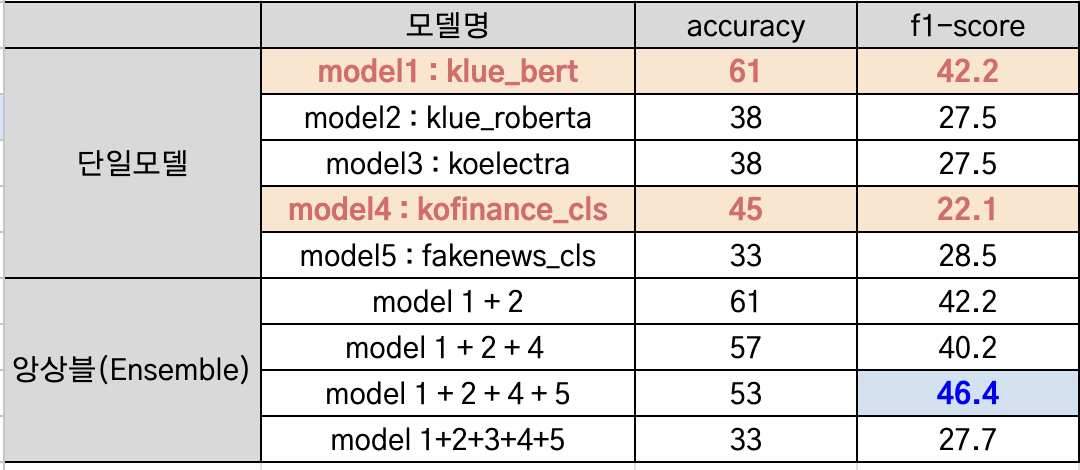

> 💡 앙상블(Ensemble) 포인트 정리
1. 학습 및 추론이 진행된 결과가 존재해야 앙상블 할 수 있으므로, 재료들을 모으는 것이 선행되야한다.
2.  어떤 모델들을 조합하느냐에 따라서 결과가 달라질 수 있다.
3. 단일모델 점수가 낮더라도  조합 시 성능이 향상될 수 있다.

###3️⃣ DAPT & TAPT 구현하기

In [ ]:
from transformers import AutoTokenizer, DataCollatorForLanguageModeling
from transformers import TrainingArguments, Trainer , AutoModelForMaskedLM
from torch.utils.data import Dataset, DataLoader, RandomSampler

import pytorch_lightning as pl
import torch

#### 3-1. 학습에 쓰일 데이터셋 만들기

- MLM 학습에 쓰이도록 Line by Line 으로 정리된 데이터셋 만들기

In [ ]:
#약 240만개 중 5만개만 사용
ex_news_dump = news_dump['text'][:50000]

In [ ]:
class LineByLineTextDataset(Dataset):
    def __init__(self, tokenizer, data, block_size):
        concated_ls = []
        # 제목 + 본문으로 합치기
        for i in range(1,len(data)):
            concated_ls.append(data[i-1] + data[i])

        batch_encoding = tokenizer(concated_ls, truncation=True, max_length=block_size)
        self.examples = batch_encoding["input_ids"]
        self.examples = [{"input_ids": torch.tensor(e, dtype=torch.long)} for e in self.examples]

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i):
        return self.examples[i]

> 아래 3가지 준비
1. 학습데이터셋
2. 평가데이터셋(편의를 위해 초반 20개)
3.  MLM용 data_collator

In [ ]:
def prepare_dataset_for_pretraining(tokenizer,train_input):
    train_dataset = LineByLineTextDataset(
        tokenizer=tokenizer,
        data=train_input,
        block_size=512,
    )
    # set mlm task
    # DataCollatorForSOP로 변경시 SOP 사용 가능 (DataCollatorForLanguageModeling)
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer, mlm=True, mlm_probability=0.15 # 0.3
    )
    eval_dataset = LineByLineTextDataset(
        tokenizer=tokenizer,
        data=train_input[:20],
        block_size=512,
    )

    return train_dataset, data_collator, eval_dataset

####3-2. 사전학습을 위한 모델 및 Trainer 준비하기

- 추가 사전학습(여기선 MLM)을 위한 Trainer 준비하기

In [ ]:
def set_trainer_for_pretraining(
        model,
        data_collator,
        dataset,
        eval_dataset,
        epoch = 10,
        batch_size = 16,
        accumalation_step = 1,):
     # set training args
    training_args = TrainingArguments(
        report_to = 'tensorboard',
        output_dir='./',
        overwrite_output_dir=True,
        num_train_epochs=epoch,
        per_device_train_batch_size=batch_size,
        gradient_accumulation_steps=accumalation_step,
        evaluation_strategy = 'steps',
        eval_steps=150,
        save_steps=150,
        save_total_limit=1,
        fp16=True,
        load_best_model_at_end=True,
        seed=42,
    )

    # set Trainer class for pre-training
    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=data_collator,
        train_dataset=dataset,
        eval_dataset=eval_dataset,
    )

    return trainer

####3-3. 사전학습 진행 및 모델파일 저장하기

In [ ]:
def pretrain():
    """MLM task 기반 사전학습 진행"""
    # fix a seed
    pl.seed_everything(seed=42, workers=False)

    # set device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("device:", device)

    # set model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")
    model = AutoModelForMaskedLM.from_pretrained("klue/bert-base")
    model.to(device)

    # set data
    train_dataset, data_collator, eval_dataset = prepare_dataset_for_pretraining(tokenizer, ex_news_dump)

    # set trainer
    trainer = set_trainer_for_pretraining(model,data_collator,train_dataset,eval_dataset)

    # train model
    print("--- Start train ---")
    trainer.train()
    print("--- Finish train ---")
    model.save_pretrained("./pretrained")

In [ ]:
pretrain()

INFO:lightning_fabric.utilities.seed:Seed set to 42


device: cuda:0


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'cls.seq_relationship.weight', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


--- Start train ---


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
150,No log,1.359738
300,No log,1.555681
450,No log,1.330693
600,1.521500,1.218143
750,1.521500,1.318099
900,1.521500,1.616304
1050,1.509300,1.624196
1200,1.509300,1.400091
1350,1.509300,1.569018
1500,1.483100,1.058283


Step,Training Loss,Validation Loss
150,No log,1.359738
300,No log,1.555681
450,No log,1.330693
600,1.521500,1.218143
750,1.521500,1.318099
900,1.521500,1.616304
1050,1.509300,1.624196
1200,1.509300,1.400091
1350,1.509300,1.569018
1500,1.483100,1.058283


--- Finish train ---


> 💡 DAPT & TAPT 파트 정리
1. 학습 시 `Pretraining > DAPT > TAPT > Fine-tunning순` 으로 진행하는게 일반적.
2. 그러나 `"DAPT + TAPT"`으로 같은 Domain/Task의 데이터셋으로 학습시키는게 시간적으로 가장 효율적이다. `(여기선 낚시성뉴스 분류 Task의 본문으로 학습)`
3.  DAPT : 풀고자하는 문제와 같은 도메인의 데이터로 학습 __(위 예시에 해당)__
4. TAPT : 풀고자하는 문제와 같은 Task의 데이터로 학습
5. 사전학습 Task 로는 MLM을 예시로 구현하였으나, datacollator를 변경하여 Next Sentence Prediction (NSP)를 사용할 수도 있다.



#Reference

- [KoEDA 깃헙레포](https://github.com/toriving/KoEDA)
- [허깅페이스](https://huggingface.co/)

In [ ]:
!pip install koeda
!pip install transformers[torch]
!pip install transformers
!pip install datasets
!pip install googletrans==4.0.0-rc1
!pip install pytorch_lightning

## Required Package

<font color=gray>
koeda <br>
transformers == 4.33.3 <br>
datasets. == 2.14.5 <br>
googletrans == 4.0.0-rcl <br>
pytorch_lightning == 2.0.9.post0 <br>
</font>


